# Chapter 2: The Core Mechanism - Self-Attention

<div class="alert alert-block alert-success">

In this chapter, we'll build a simplified self-attention mechanism from scratch. The goal is to develop a strong intuition for the three key steps involved:

1.  **Calculating attention scores.**
2.  **Normalizing scores into attention weights.**
3.  **Creating context vectors** as a weighted sum of the inputs.

We will start with simple loops for clarity and then show how to achieve the same result with efficient, vectorized matrix multiplication.
</div>

## 2.1 Imports and Setup

<div class="alert alert-block alert-success">
    
Set up our environment with the necessary imports.
</div>

In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # required for 3D plotting

## 2.2 Simplified Attention Example

<div class="alert alert-block alert-success">
Let's begin with a sample sentence that has already been converted into a tensor of embedding vectors. For this example, we have 6 tokens, and each token is represented by a 3-dimensional embedding vector.
</div>

In [2]:
# Our sample input sentence as embedding vectors
inputs = torch.tensor(
    [[ 0.8938,  0.9003,  0.8978], # Your
     [ 0.7165,  0.3428,  0.2553], # journey
     [ 0.1042,  0.5163,  0.3753], # starts
     [ 0.0445,  0.3091,  0.9763], # with
     [ 0.1554,  0.1614,  0.2700], # one
     [ 0.8089,  0.9435,  0.5480]] # step
)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

<div class="alert alert-block alert-info">
Each row represents a word, and each column represents an embedding dimension
</div>

<div class="alert alert-block alert-success">
Let's plot our embedding vectors for a better visualization.
</div>

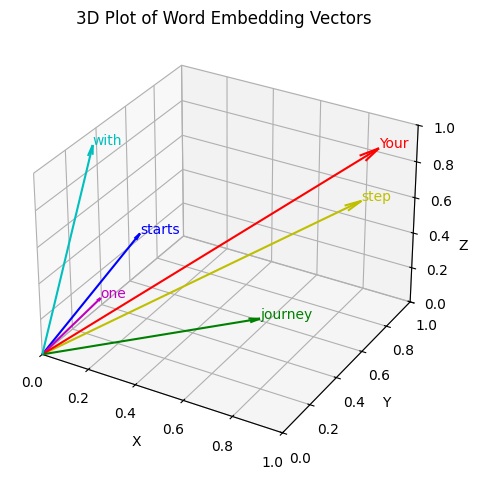

In [3]:
# Extract x, y, z coordinates
x_coords = inputs[:,0].numpy()
y_coords = inputs[:,1].numpy()
z_coords = inputs[:,2].numpy()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vectot with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio = 0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set lables for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.text2D(1.06, 0.5, "Z", transform=ax.transAxes, fontsize=10, va='center', ha='center')

# Set plot limits
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embedding Vectors')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

The plot above helps us visualize our word embeddings as vectors in a 3D space. The core idea of <b>self-attention</b> is to refine these vectors by allowing them to interact with each other.

To do this, each token in our sequence will play three roles: a <b>query</b>, a <b>key</b>, and a <b>value</b>

* The <b>query</b> vector represents the current token that is "looking for" context.

* The <b>key</b> vectors represent all the other tokens in the sequence that the query will "interview" or compare itself against.
  
* The <b>value</b> vectors are the actual content of the tokens that will be blended together to form the new, context-aware vector.

In this simplified version of self-attention, a single input vector will play all three roles.
</div>

## 2.3 Calculating Attention Scores

<div class="alert alert-block alert-success">

The first step is to calculate the <b>attention scores</b>. For a given query, we measure its similarity to every key in the sequence. A simple and effective way to measure this similarity is the <b>dot product</b> A higher dot product score means the query and key vectors are more aligned and thus more relevant to each other.
</div>

<div class="alert alert-block alert-info">
Let's now consider the second element of our inputs tensor ("journey") as our query and calculate its attention scores against all other tokens.
</div>

In [4]:
query = inputs[1] # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product

print(attn_scores_2)

tensor([1.1782, 0.6961, 0.3475, 0.3871, 0.2356, 1.0429])


<div class="alert alert-block alert-success">
In the next step, we normalize each of the attention scores that we computed previously.
</div>

## 2.4 Calculating Attention Weights with Softmax

<div class="alert alert-block alert-success">

The raw attention scores must be normalized into <strong>attention weights</strong> to create a clear distribution of focus.
    
The goal is to produce a set of positive values that sum to 1. This allows for stable model training and makes the results interpretable as the relative importance of each token.

Here's a straightforward method for achieving this normalization step:
</div>

In [5]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.3031, 0.1791, 0.0894, 0.0996, 0.0606, 0.2683])
Sum: tensor(1.)


<div class="alert alert-block alert-success">
    
In practice, it's more common and advisable to use the **softmax function** for normalization.

This approach is better at managing extreme values and offers more favorable gradient properties during training. 

Below is a basic implementation of the softmax function for normalizing the attention scores: 
</div>

In [6]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.2653, 0.1638, 0.1156, 0.1203, 0.1034, 0.2317])
Sum: tensor(1.0000)


<div class="alert alert-block alert-info">

As the output shows, the softmax function also meets the objective and normalizes the attention weights such that they sum to 1.
</div>

<div class="alert alert-block alert-info">
    
  <b>A Note on the Properties of Softmax</b><br>
  
  The softmax function is crucial because it converts raw, unbounded attention scores into a meaningful probability distribution. It achieves this through two key properties:

  * <b>Ensures Positivity:</b> The exponential function ($e^x$) ensures every output weight is a positive number, a requirement for any probability.
    
  * <b>Amplifies the "Winner":</b> The exponential function grows non-linearly, which exaggerates the differences between the scores. A token with a slightly higher score will receive a much larger portion of the total probability after softmax is applied. This "winner-takes-most" effect allows the model to focus confidently on the most relevant tokens for a given context.

  Because the resulting weights are all positive and sum to 1, we can interpret them as the model's confidence in the importance of each token.
</div>

<div class="alert alert-block alert-warning">

Note that this naive softmax implementation (`softmax_naive`) may encounter **numerical instability problems**, such as **overflow** and **underflow**, when dealing with large or small input values. 

Therefore, in practice, it's advisable to use the **PyTorch implementation of softmax**, which has been extensively optimized for performance:
</div>

In [7]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.2653, 0.1638, 0.1156, 0.1203, 0.1034, 0.2317])
Sum: tensor(1.)


<div class="alert alert-block alert-info">

In this case, we can see that it yields the same results as our previous softmax_naive function.
</div>

## 2.5 Creating the Context Vector

<div class="alert alert-block alert-success">

The context vector z(2) is calculated as a weighted sum of all input vectors. 

This involves multiplying each **value vector** (which in this simple case is the input vector) by its corresponding attention weight:
</div>

In [8]:
query = inputs[1] # 2nd input is the query

context_vec_2 = torch.zeros(query.shape)

for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i

print(context_vec_2)

tensor([0.5754, 0.6271, 0.5957])


<div class="alert alert-block alert-success">
Now, we can extend this computation to calculate attention weights and context vectors for all inputs.
</div>

<div class="alert alert-block alert-success">
First, we add an additional for-loop to compute the dot products for all pairs of inputs.
</div>

In [9]:
attn_scores = torch.empty(inputs.shape[0], inputs.shape[0])

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i,j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[2.4155, 1.1782, 0.8949, 1.1946, 0.5266, 2.0644],
        [1.1782, 0.6961, 0.3475, 0.3871, 0.2356, 1.0429],
        [0.8949, 0.3475, 0.4183, 0.5306, 0.2009, 0.7771],
        [1.1946, 0.3871, 0.5306, 1.0507, 0.3204, 0.8626],
        [0.5266, 0.2356, 0.2009, 0.3204, 0.1231, 0.4259],
        [2.0644, 1.0429, 0.7771, 0.8626, 0.4259, 1.8448]])


<div class="alert alert-block alert-info">
Each element in the preceding tensor represents an attention score between each pair of inputs. </div>

## 2.6 Vectorization: From Loops to the Full Attention Matrix

<div class="alert alert-block alert-success">
    
The `for` loops we used previously are great for understanding the logic step-by-step, but they are very inefficient.The standard, high-performance way to implement self-attention is with **vectorized operations**.

We will now replace all the loops with two efficient matrix multiplications:

<ol>
    <li style="font-weight:bold"><span style="font-weight:normal">First, we'll calculate all the attention scores at once with a matrix multiplication. (<code>scores = queries @ keys.T</code>)</span></li>
    <li style="font-weight:bold"><span style="font-weight:normal">Then, after applying softmax to get the weights, we'll calculate all the final context vectors at once with a second matrix multiplication.</span></li>
    
</ol>


This vectorized approach is fundamental to making deep learning models fast and is a core concept in libraries like PyTorch.
</div>

In [19]:
attn_scores = inputs @ inputs.T # scores = queries @ keys.T
print(attn_scores)

tensor([[2.4155, 1.1782, 0.8949, 1.1946, 0.5266, 2.0644],
        [1.1782, 0.6961, 0.3475, 0.3871, 0.2356, 1.0429],
        [0.8949, 0.3475, 0.4183, 0.5306, 0.2009, 0.7771],
        [1.1946, 0.3871, 0.5306, 1.0507, 0.3204, 0.8626],
        [0.5266, 0.2356, 0.2009, 0.3204, 0.1231, 0.4259],
        [2.0644, 1.0429, 0.7771, 0.8626, 0.4259, 1.8448]])


<div class="alert alert-block alert-success">
We now normalize each row using softmax so that the values in each row sum to 1:
</div>

In [17]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.3761, 0.1091, 0.0822, 0.1109, 0.0569, 0.2647],
        [0.2653, 0.1638, 0.1156, 0.1203, 0.1034, 0.2317],
        [0.2335, 0.1351, 0.1450, 0.1622, 0.1167, 0.2076],
        [0.2524, 0.1126, 0.1300, 0.2186, 0.1053, 0.1811],
        [0.2060, 0.1540, 0.1487, 0.1676, 0.1376, 0.1862],
        [0.3409, 0.1227, 0.0941, 0.1025, 0.0662, 0.2736]])


<div class="alert alert-block alert-warning">

In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies the dimension of the input tensor along which the function will be computed. 

By setting dim=-1, we are instructing the softmax function to apply the normalization along the last dimension of the attn_scores tensor. 

If attn_scores is a 2D tensor (for example, with a shape of **[rows, columns]), dim=-1** will normalize across the columns so that the values in each row (summing over the column dimension) sum up to 1.
    
</div>

<div class="alert alert-block alert-success">
Let's briefly verify that the rows indeed all sum to 1:
</div>

In [12]:
attn_weights.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

<div class="alert alert-block alert-success">
In the third and last step, we now use these attention weights to compute all context vectors via matrix multiplication:
</div>

In [13]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.6508, 0.7117, 0.6651],
        [0.5754, 0.6271, 0.5957],
        [0.5138, 0.5962, 0.6022],
        [0.4924, 0.5884, 0.6453],
        [0.4894, 0.5647, 0.5828],
        [0.6386, 0.6981, 0.6405]])


<div class="alert alert-block alert-success">
We can double-check that the code is correct by comparing the 2nd row with the context vector z(2) calculated previously.
</div>

In [14]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.5754, 0.6271, 0.5957])


## Chapter 2 Summary and Next Steps

This concludes our first-principles implementation of a simplified self-attention mechanism. We've built the core logic from the ground up, moving from intuitive loops to efficient, vectorized matrix operations.

<div class="alert alert-block alert-info">
    
<b>Milestone Reached: The Foundation of Attention is Built!</b>

Throughout this chapter, we have:

* Understood the three roles of an input token: as a **Query**, a **Key**, and a **Value**.
* Calculated **attention scores** by measuring the similarity between queries and keys using the dot product.
* Normalized these scores into **attention weights** using the softmax function.
* Computed the final **context vectors** as a weighted sum of the value vectors, allowing tokens to exchange information.
 
</div>

### Where We Are Now
We now have a working self-attention mechanism that can produce context-aware embeddings. However, this version is not yet "trainable." The Query, Key, and Value for each token are all derived from the same initial input vector, which limits its flexibility.
 
### What's Next?
To make this mechanism truly powerful, we need to allow the model to <i>learn</i> how to create specialized queries, keys, and values. In the next notebook, **Chapter 3: Building a Production-Ready Attention Module**, we will introduce trainable weight matrices (Wq, Wk, Wv) to unlock the full learning potential of self-attention.
